In [1]:
!git clone https://github.com/AvonYangXX1/AMPLify-Feedback.git
!pip install Levenshtein
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import numpy as np
import math
import matplotlib.pyplot as plt
import statistics
from Levenshtein import distance as lev
import pandas as pd

fatal: destination path 'AMPLify-Feedback' already exists and is not an empty directory.


In [2]:
generator = tf.keras.models.load_model('AMPLify-Feedback/model_weights/PeptideGenerator_new.keras')

In [3]:
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input0 (InputLayer)         [(None, 2)]               0         
                                                                 
 Dense0 (Dense)              (None, 256)               768       
                                                                 
 Norm0 (BatchNormalization)  (None, 256)               1024      
                                                                 
 Dense1 (Dense)              (None, 256)               65792     
                                                                 
 Norm1 (BatchNormalization)  (None, 256)               1024      
                                                                 
 Dense2 (Dense)              (None, 256)               65792     
                                                                 
 Norm2 (BatchNormalization)  (None, 256)               1024  

In [4]:
discriminator = tf.keras.models.load_model('/content/AMPLify-Feedback/model_weights/PeptideDiscriminator_new.keras')

In [5]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D (Conv1D)             (None, 186, 32)           6912      
                                                                 
 Flatten (Flatten)           (None, 5952)              0         
                                                                 
 Dense0 (Dense)              (None, 512)               3047936   
                                                                 
 Dropout (Dropout)           (None, 512)               0         
                                                                 
 Dense1 (Dense)              (None, 256)               131328    
                                                                 
 Output (Dense)              (None, 1)                 257       
                                                                 
Total params: 3186433 (12.16 MB)
Trainable params: 0 

In [6]:
def create_oracle():
    inputs0 = tf.keras.layers.Input((190,43),name="SeqInput")
    inputs1 = tf.keras.layers.Input((326,),name="StateInput")
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_0")(inputs0) # kernel_size=5 works well
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_1")(x) # Just two layers work better
    x = tf.keras.layers.Flatten(name="Flatten_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnSeqDense_0")(x)
    x = tf.keras.layers.Concatenate(axis=1, name="Concat")([x, inputs1])
    x = tf.keras.layers.Dense(1024, activation="relu", name="LearnConcatDense_0")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnConcatDense_1")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_1")(x)
    x = tf.keras.layers.Dense(1, activation="linear", name="Output")(x)
    model = tf.keras.models.Model([inputs0, inputs1], x, name="MICPredictor")
    return model

In [7]:
oracle = create_oracle()
path = "AMPLify-Feedback/model_weights/MICPredictor"
for i, layer in enumerate(oracle.layers):
    weights = np.load(f"{path}/layer_{i}_weights.npy", allow_pickle=True)
    layer.set_weights(weights)

In [8]:
oracle.summary()

Model: "MICPredictor"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 SeqInput (InputLayer)       [(None, 190, 43)]            0         []                            
                                                                                                  
 Conv1D_0 (Conv1D)           (None, 186, 128)             27648     ['SeqInput[0][0]']            
                                                                                                  
 Conv1D_1 (Conv1D)           (None, 182, 128)             82048     ['Conv1D_0[0][0]']            
                                                                                                  
 Flatten_0 (Flatten)         (None, 23296)                0         ['Conv1D_1[0][0]']            
                                                                                       

In [9]:
aa_vocal = np.load("AMPLify-Feedback/model_weights/SeqTV_vocal.npy")
pep_decoder = tf.keras.layers.StringLookup(vocabulary=aa_vocal[1:], invert=True, oov_token='')
species_vocal = np.load("AMPLify-Feedback/model_weights/SpeciesTV_vocal.npy")
species_decoder = tf.keras.layers.StringLookup(vocabulary=species_vocal[1:], invert=True, oov_token='')

In [10]:
# GAN
def compile_gan(generator, discriminator):
    discriminator.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=[tf.keras.metrics.FalsePositives(),
                                   tf.keras.metrics.FalseNegatives()])
    discriminator.trainable = False
    gan_input0 = layers.Input(shape=(latent_dim,))
    gan_output = discriminator(generator(gan_input0))
    gan = tf.keras.Model(gan_input0, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4))
    return gan

In [11]:
def fit_gan(generator, discriminator, gan, data, epochs, batch_size, latent_dim):
    demo_noise = noise = (np.random.rand(1, latent_dim)-0.5)*2
    sequences = data["Onehot_sequence"]
    sequences = np.array([np.array(s) for s in sequences])
    for epoch in range(epochs):
        total_d_loss = 0
        total_g_loss = 0
        num_batches = int(sequences.shape[0] / batch_size)
        for i in range(0, sequences.shape[0], batch_size):
            real_sequences = sequences[i:i + batch_size]
            current_batch_size = real_sequences.shape[0]
            labels = np.ones((current_batch_size, 1))
            noise = (np.random.rand(current_batch_size, latent_dim)-0.5)*2

            # Train discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(real_sequences, labels, return_dict=True)
            discriminator.trainable = False

            # Train generator
            noise = np.random.normal(0, 1, (current_batch_size, latent_dim))
            g_loss = gan.train_on_batch(noise, np.ones((current_batch_size, 1)))

            # Print the progress
            total_d_loss += d_loss["loss"]
            total_g_loss += g_loss

        #Print a sampled sequence to follow structural evolution
        demo_seq = generator(demo_noise)
        demo_seq = tf.math.argmax(demo_seq, axis=2)
        demo_seq = pep_decoder(demo_seq).numpy().astype('str')
        demo_seq = ["".join(chars) for chars in demo_seq]
        print(demo_seq[0])
        print(f"Epoch {epoch+1}/{epochs}; D_Loss {total_d_loss/num_batches:.4f}; G_Loss {total_g_loss/num_batches:.4f}")
        return total_d_loss, total_g_loss

In [12]:
def generate_sequences(generator, latent_dim, num_sequences):
    noise = (np.random.rand(num_sequences, latent_dim)-0.5)*2
    generated_sequences = generator.predict(noise, verbose=0)
    return onehot2seq(generated_sequences)

In [13]:
def onehot2seq(onehot):
  decoded_sequences = []
  for s in onehot:
    chars_array = pep_decoder(tf.math.argmax([s], axis=2)).numpy().astype('str')
    decoded_sequences += ["".join(chars) for chars in chars_array]
  return decoded_sequences

def seq2onehot(seq):
  for s in seq:
    SeqTV = tf.keras.layers.TextVectorization(max_tokens=50, standardize=None, split="character",
                                          pad_to_max_tokens=True,
                                          output_sequence_length=190,
                                          output_mode="int", name="SeqTextVectorizer")
    SeqTV.adapt(seq)
  return SeqTV(seq).numpy()

In [14]:
def coordinates_grid(num_bins) :
  labels = np.round(np.linspace(-1, 1, num_bins), 2)
  noise = []
  for x in labels:
    for y in labels:
        noise.append([x, y])
  noise = np.array(noise)
  num_sequences = len(noise)
  return noise, num_sequences, labels

In [15]:
def hallucination_mapping(num_bins, target):
  #Search coordinates in the noise plane
  noise, num_sequences, labels = coordinates_grid(num_bins)
  # Look up the index of the target bacteria
  bacteria = np.zeros(shape=(num_sequences, 326))
  index = np.where(species_vocal==target)[0][0]
  bacteria[:, index] = 1
  return noise, num_sequences, bacteria

In [16]:
def selected_data(hallucination_data, n_max, MIC_threshold) :
  #Order by increasing MIC and select the top n_max sequences
  hallucination_data['MIC'].sort_values(ascending=True).head(n_max)
  #Exclude if above MIC_theshold
  hallucination_data = hallucination_data[hallucination_data.MIC.astype(np.float64) < MIC_threshold]
  return hallucination_data

In [17]:
def RL_loop(generator, discriminator, gan, oracle, num_sequences, epochs, aa_vocal, pep_decoder, latent_dim, MIC_threshold, n_max, n_bins, target):
  d_loss, d_accuracy, g_loss, average_mic_train, min_mic_train, max_mic_train, median_mic_train, levenstein  = [], [], [], [], [], [], [], []
  for i in range (n_iter_max) :
    #Sequences prediction
    noise, num_sequences, bacteria = hallucination_mapping(n_bins, target)
    generated_onehot = generator.predict(noise, verbose=0)
    generated_sequences = onehot2seq(generated_onehot)

    #Oracle results and statistics
    MIC = oracle.predict([generated_onehot, bacteria], verbose=0)
    average_mic_train += [np.mean(MIC)]
    min_mic_train += [np.min(MIC)]
    max_mic_train += [np.max(MIC)]
    median_mic_train += [np.median(MIC)]
    levenstein += [variability_metrics(generated_sequences, aa_vocal, pep_decoder)]

    #Evaluatiuon of the generated sequences with the oracle results
    hallucination_data = np.concatenate([noise, MIC], axis=1)
    hallucination_data = pd.DataFrame(hallucination_data, columns=["Noise_1", "Noise_2", "MIC"])
    hallucination_data["Onehot_sequence"] = np.array(generated_onehot).reshape(num_sequences, -1, 43).tolist()
    data_subset = selected_data(hallucination_data, n_max, MIC_threshold)

    #Fitting of the generator
    d_results, g_results = fit_gan(generator, discriminator, gan, data_subset, epochs=epochs, batch_size=num_sequences, latent_dim=latent_dim)
    d_loss += [d_results]
    g_loss += [g_results]

  return d_loss, g_loss, average_mic_train, min_mic_train, max_mic_train, median_mic_train, levenstein

In [18]:
def variability_metrics(sequences, aa_vocal, pep_decoder):
  total_lev = 0
  index = 0
  for s1 in range(len(sequences)):
                for s2 in range(s1+1,len(sequences)):
                        total_lev += lev(sequences[s1],sequences[s2])
                        index += 1
  return total_lev/index

In [19]:
def display(parameters):
  for p in list(parameters.keys()):
    plt.plot(range(len(parameters[p])), parameters[p], linestyle='-', label = p)
  plt.legend(loc = "upper right")
  plt.ylabel("Value")
  plt.xlabel("Iteration index")
  plt.title("Performances with the feedback loop")
  plt.show()

Stats oracle
EVGALEGKQKKLAK
Epoch 1/2; D_Loss 5.9482; G_Loss 6.4201
Stats oracle
IVIKSLDLK
Epoch 1/2; D_Loss 5.8151; G_Loss 6.2796
Stats oracle
EVGAkDGKkKLLK
Epoch 1/2; D_Loss 5.7120; G_Loss 6.0998
Stats oracle
ADGYkDDKHKPK
Epoch 1/2; D_Loss 5.5594; G_Loss 5.9744
Stats oracle
EVGALEGKIKKLAPK
Epoch 1/2; D_Loss 5.4528; G_Loss 5.7778
Stats oracle
DALDPIF
Epoch 1/2; D_Loss 5.3038; G_Loss 5.7125
Stats oracle
DALDI
Epoch 1/2; D_Loss 5.1744; G_Loss 5.5482
Stats oracle
DAI
Epoch 1/2; D_Loss 5.0504; G_Loss 5.3982
Stats oracle
AVTVSGDLK
Epoch 1/2; D_Loss 4.9011; G_Loss 5.2172
Stats oracle
DALDPI
Epoch 1/2; D_Loss 4.8254; G_Loss 5.0782
Stats oracle
EVGALLGKFAKLA
Epoch 1/2; D_Loss 4.6743; G_Loss 4.9548
Stats oracle
ADTYFDDAKPD
Epoch 1/2; D_Loss 4.5543; G_Loss 4.7879
Stats oracle
DVGATTGMF
Epoch 1/2; D_Loss 4.4362; G_Loss 4.6781
Stats oracle
ADTVSGDLK
Epoch 1/2; D_Loss 4.3281; G_Loss 4.5334
Stats oracle
DALDPI
Epoch 1/2; D_Loss 4.2109; G_Loss 4.3965
Stats oracle
DALDPI
Epoch 1/2; D_Loss 4.0993; G_L

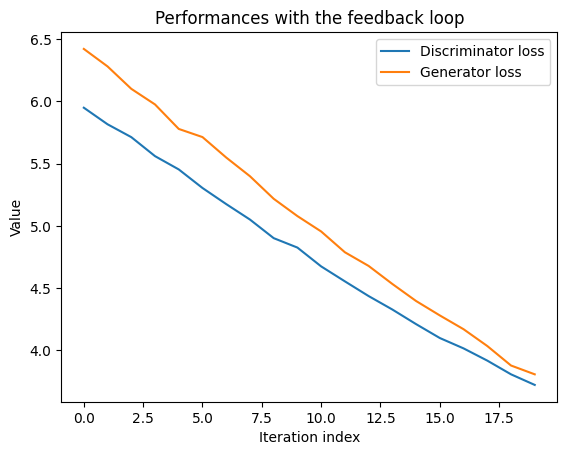

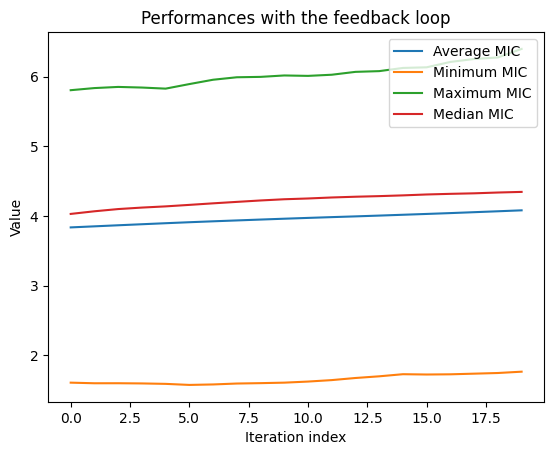

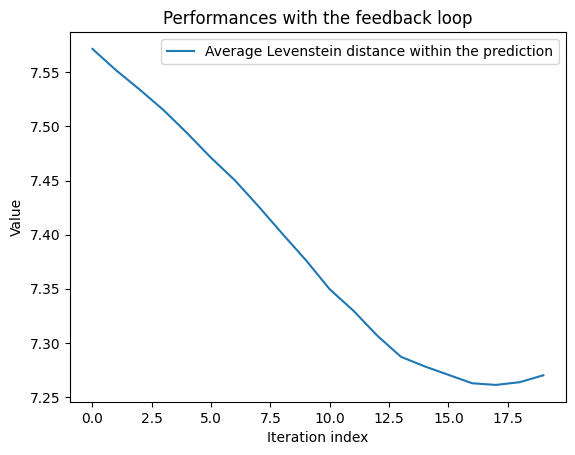

['GAGATGF',
 'GALDG',
 'AVTVSGDLK',
 'DVGRLDGKHKLK',
 'DALDPI',
 'ADTVSGDLK',
 'GVLKLLKKL',
 'GALDGF',
 'EVGALEGKIKKLAPK',
 'IVIKLLDLH']

In [20]:
latent_dim = 2
num_sequences = 1000
n_iter_max = 20
epochs = 2

MIC_threshold = math.log(100,2)
n_max = 500
n_bins = 101
target = 'Bacillus_subtilis'

gan = compile_gan(generator, discriminator)
d_loss, g_loss, average_mic_train, min_mic_train, max_mic_train, median_mic_train, levenstein = RL_loop(generator, discriminator, gan, oracle, num_sequences, epochs, aa_vocal, pep_decoder, latent_dim, MIC_threshold, n_max, n_bins, target)
display({"Discriminator loss" : d_loss, "Generator loss" : g_loss})
display({"Average MIC" : average_mic_train, "Minimum MIC" : min_mic_train, "Maximum MIC" : max_mic_train, "Median MIC" : median_mic_train})
display({"Average Levenstein distance within the prediction" : levenstein})
generate_sequences(generator, latent_dim, 10)